In [1]:
from jupyter_notebooks.effective_cdm import flamingo_colours
%load_ext autoreload
%autoreload 2

In [2]:
import os
from importlib import reload

import torch
import numpy as np
import sciplots as plots
from scipy import stats
from sklearn.decomposition import PCA
from netloader.utils.utils import get_device

from src.utils import data, analysis
from src.utils.utils import open_config, overlap

reload(data)
reload(analysis)

from src.utils import analysis
from src.utils.data import DarkDataset, loader_init

In [53]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = config['output']['plots-directory']

bahamas_colours = ['#0008E0', '#004FE0', '#0097E0', '#00DCE0']
bahamas_agn_colours = ['#F54EDF', '#5D4EF5']
bahamas_dmo = ['#01FB3D', '#00FA8F', '#89FA00']
flamingo_colours = ['#FA2100', '#FABD00', '#FA7700']
flamingo_test = ['#FA07A0']
colours = ['k'] + bahamas_dmo[:1] + bahamas_colours[:1] + bahamas_colours[1:2] + bahamas_dmo[-1:] + bahamas_colours[-2:]
# colours = ['k'] + bahamas_colours

In [81]:
known = [
    'bahamas_cdm',
    # 'bahamas_cdm_low',
    # 'bahamas_cdm_hi',
    'bahamas_0.1',
    'bahamas_0.3',
    'bahamas_1',
    # 'bahamas_dmo_cdm',
    # 'bahamas_dmo_0.1',
    # 'bahamas_dmo_1',
    # 'flamingo',
    # 'flamingo_low',
    # 'flamingo_hi',
    'darkskies_cdm',
    # 'darkskies_0.1',
    'darkskies_0.2',
]
# unknown = ['bahamas_dmo_cdm', 'bahamas_dmo_0.1', 'bahamas_dmo_1', 'noise']
unknown = [
    # 'flamingo_low_test',
    # 'bahamas_dmo_0.1',
    # 'noise',
    'darkskies_0.1',
]

dataset = DarkDataset(config['data']['data-dir'], known, unknown)
dataset.labels = dataset.unique_labels(dataset.labels, dataset.sims)

net = torch.load(os.path.join(config['output']['network-states-directory'], 'network_v8_44.3.0.pth'), weights_only=False)
net.to(get_device()[1])
net.transforms['inputs'][1]._shape = dataset.images.shape[1:]
dataset.images = net.transforms['inputs'](dataset.images)
dataset.labels = net.transforms['targets'](dataset.labels)
print(net)

loaders = loader_init(dataset, batch_size=config['training']['batch-size'], val_frac=config['training']['validation-fraction'], idxs=net.idxs)

data = net.predict(loaders[1])
# data['targets'] = dataset.correct_unknowns(data['targets'].squeeze())
# data['targets'] = dataset.unique_labels(data['targets'], dataset.sims[data['ids'].astype(int)])
data['targets'] = data['targets'].squeeze()
labels = dataset.names[data['ids'][np.unique(
    data['targets'],
    return_index=True,
)[1]].astype(int)]

Architecture: CompactClusterEncoder
Description: DARKSKIES-0.2, DARKSKIES-0.1, Final DMO, (K 1e-2, NX, UL)
Network: network_v8
Epoch: 150
Optimiser: AdamW
Scheduler: ReduceLROnPlateau
Args: (method: median, center_step: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], similarity_weight: 0, class_weight: 1, compact_weight: 0, distance_weight: 1, steps: 3, cluster_weight: 2.2)

Training data size: 14400	Validation data size: 3600
Prediction time: 1.039e+00 s


In [79]:
data['latent'][:, 0] *= 1e6
# pca = PCA(n_components=4).fit(data['latent'][np.isin(data['targets'], np.unique(data['targets'])[net._unknown:])])
pca = PCA(n_components=4).fit(data['latent'])
pca_transform = pca.transform(data['latent'])
pca_transform[:, 0] /= 1e6
data['latent'][:, 0] /= 1e6

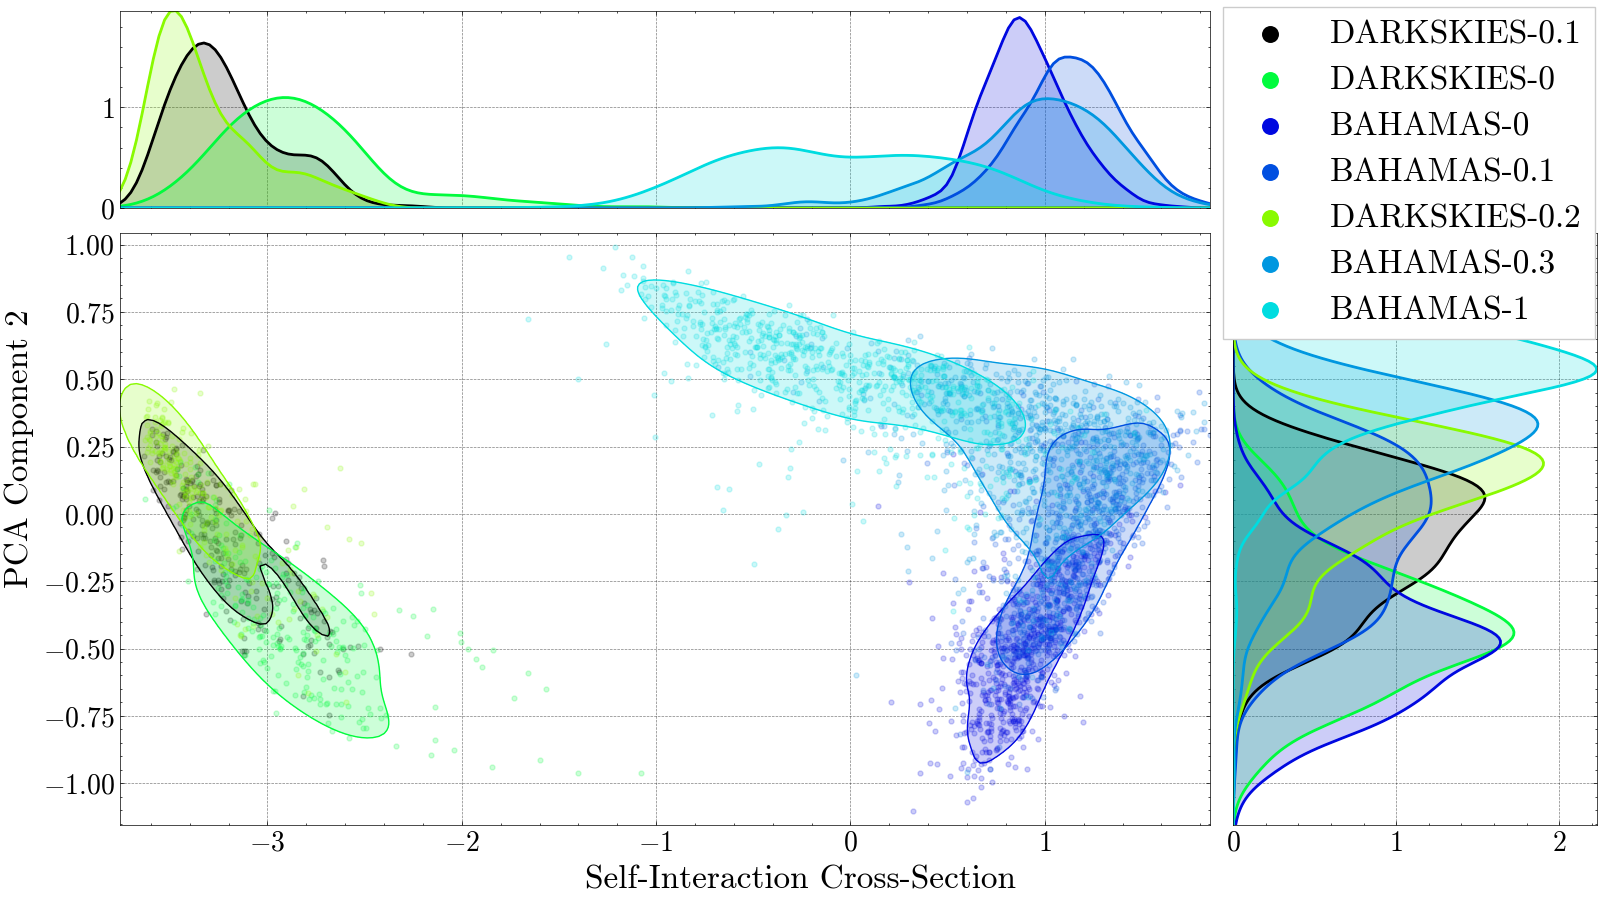

In [80]:
plot = plots.PlotClusters(
    pca_transform[:, :2][:, ::-1],
    data['targets'],
    # data['targets'] != np.unique(data['targets'])[4],
    # norm=True,
    density=True,
    x_label='Self-Interaction Cross-Section',
    y_label='PCA Component 2',
    labels=labels.tolist(),
    # labels=['BAHAMAS-DMO-0.1', 'Known Sims'],
    colours=colours,
    # colours=['k'] + bahamas_colours[:1],
    alpha_marker=0.2,
    alpha_2d=0.2,
    # rows=int(len(labels) / 2),
    cols=1,
    loc='upper right',
)

ValueError: zero-size array to reduction operation minimum which has no identity

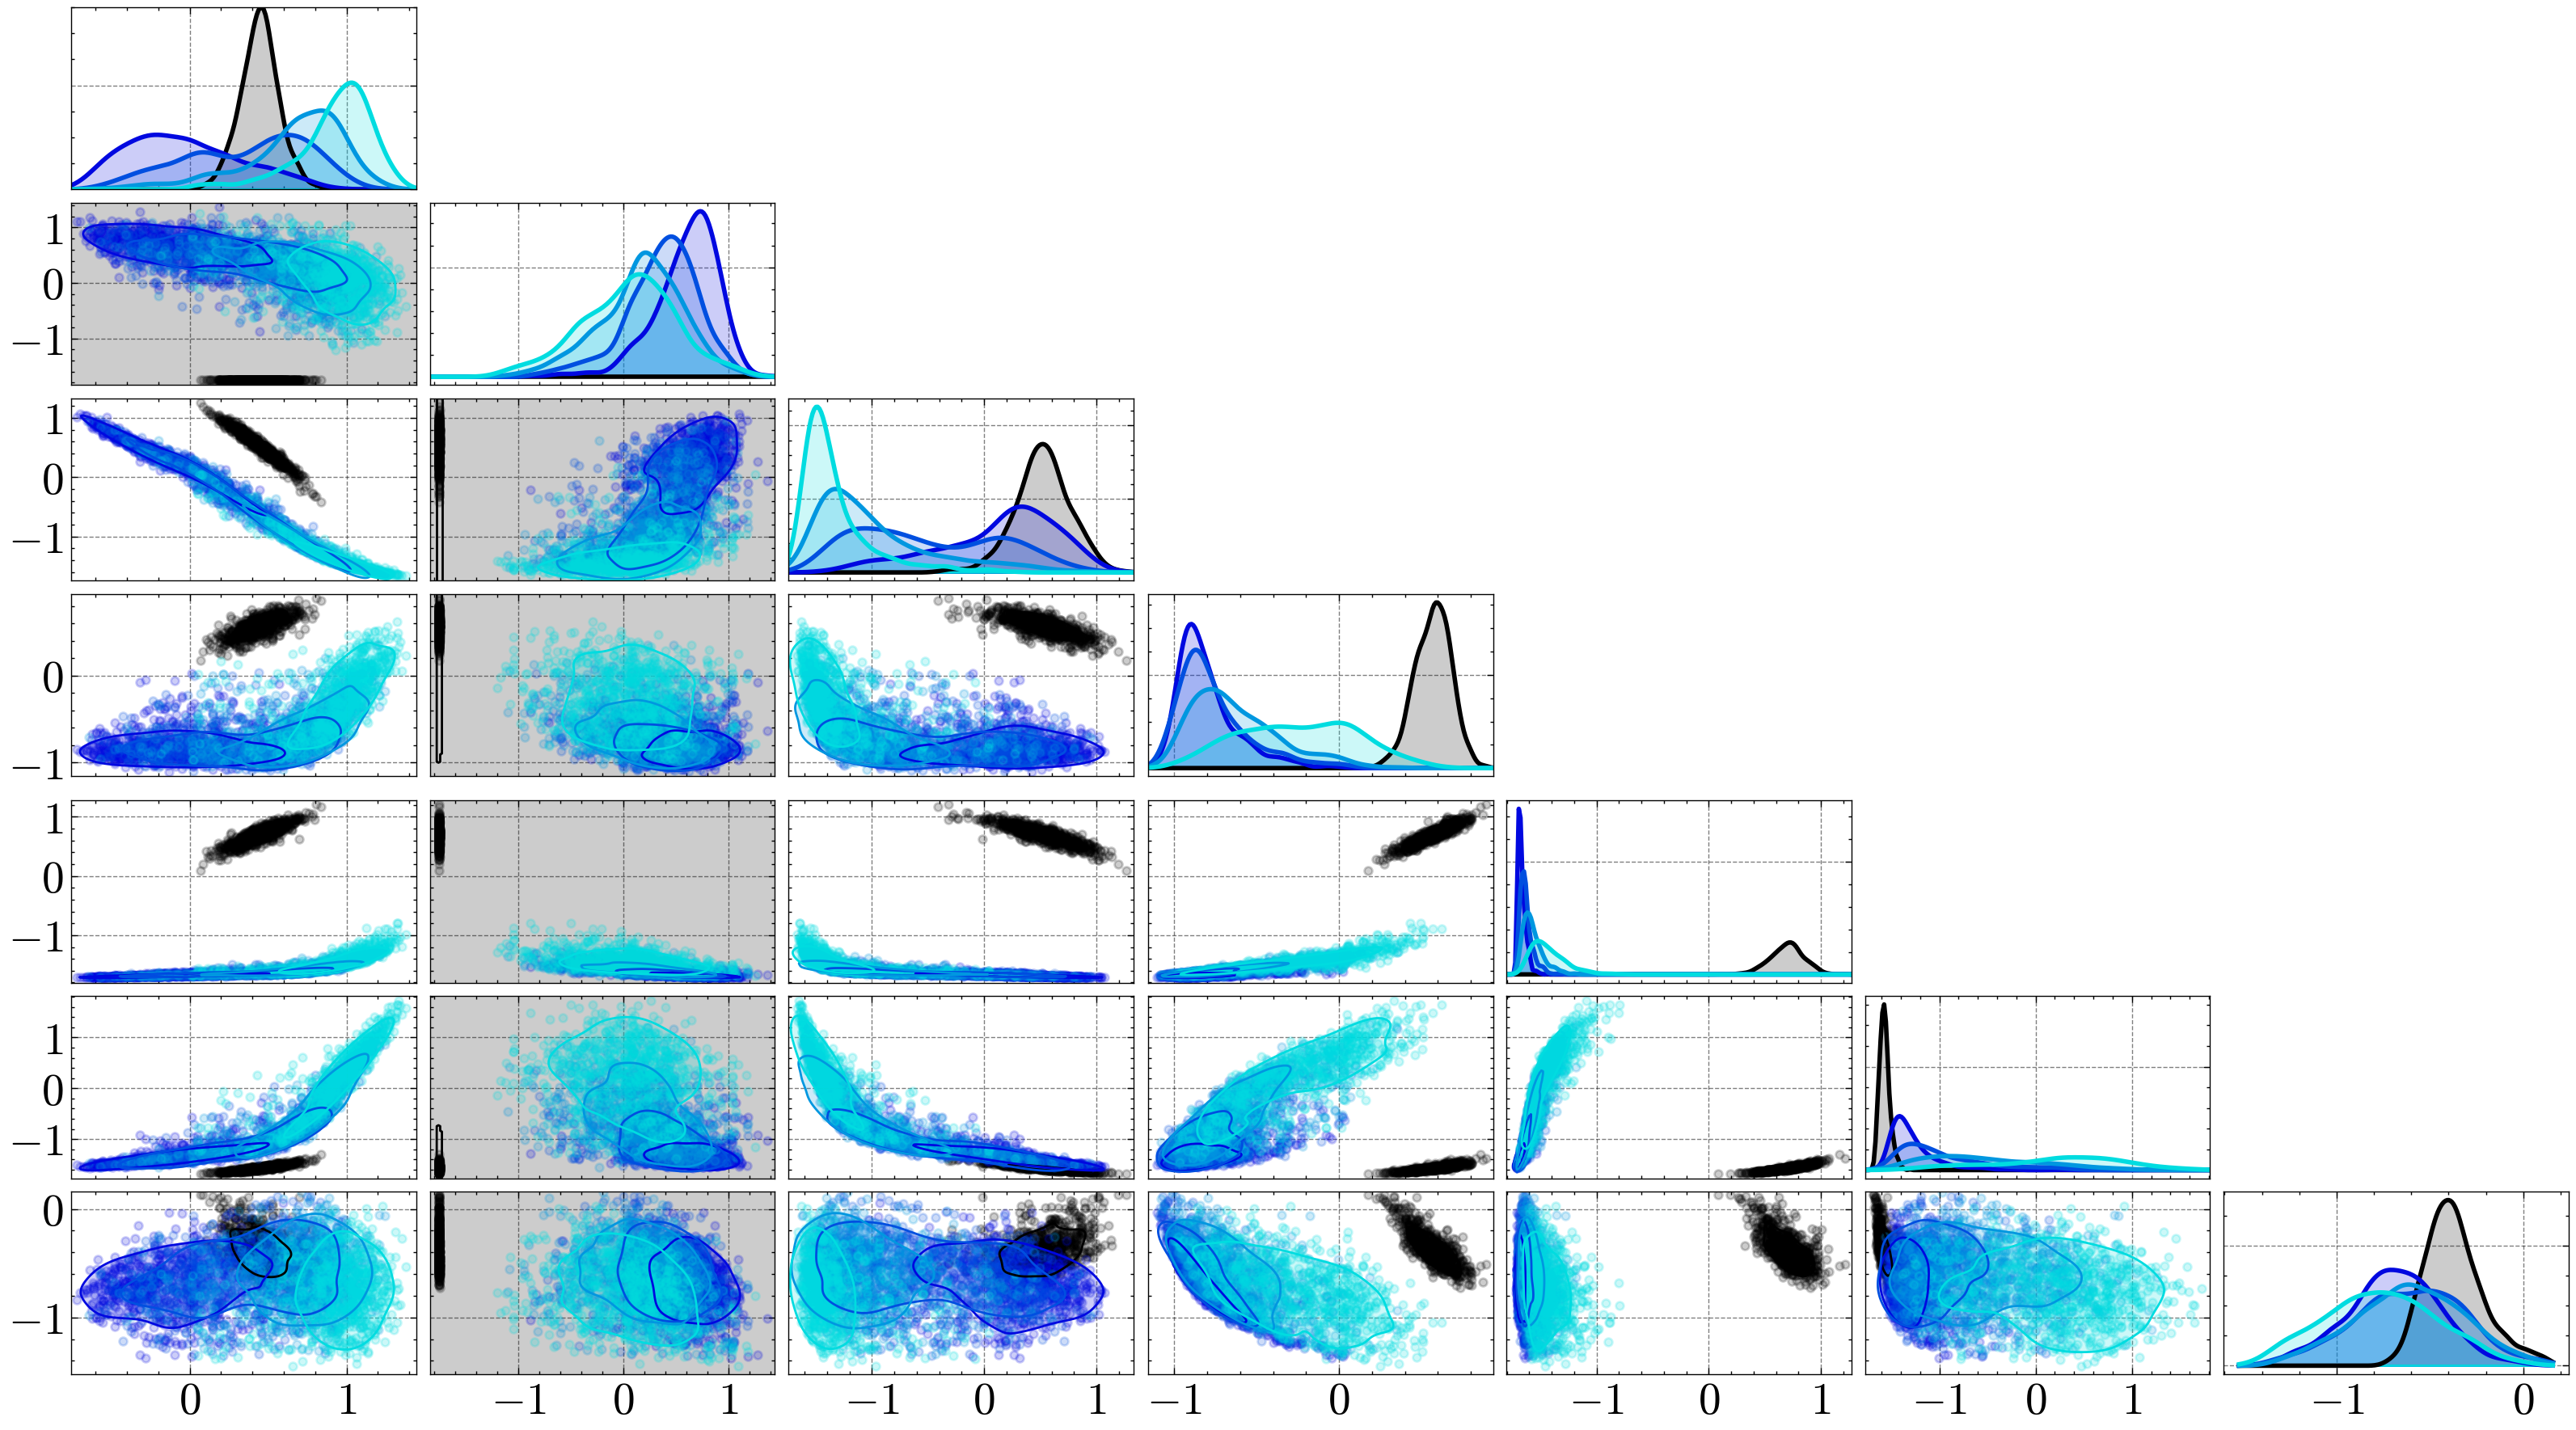

In [33]:
plot = plots.PlotClusters(
    data['latent'][:, :],
    data['targets'],
    # norm=True,
    density=True,
    labels=labels.tolist(),
    colours=colours,
    alpha_marker=0.2,
    alpha_2d=0.2,
    # rows=int(len(labels) / 2),
    rows=len(labels),
    loc='upper right',
)

In [4]:
def cluster_loss(latent, labels, cluster_class):
    centers = []

    for label in np.unique(labels):
        idxs = label == labels
        centers.append(np.mean(latent[idxs], axis=0))

    centers = np.stack(centers)

    idxs = np.unique(labels) == cluster_class
    class_vecs = latent[labels == cluster_class] - centers[idxs]

    # Direction to the other classes
    direcs = centers[~idxs] - centers[idxs]

    # Projected vectors for the target class in the direction of the other classes
    proj_vecs = class_vecs @ direcs.T / np.linalg.norm(direcs, axis=-1)

    # Average scatter in the direction of the other classes
    return proj_vecs, np.linalg.norm(direcs, axis=-1) / np.std(proj_vecs, axis=0)

In [5]:
idx = 0
_, stds = cluster_loss(data['latent'], data['targets'], np.unique(data['targets'])[idx])
print(f"Target Sim: {labels[idx]}\n{'\n'.join([f'Sim: {sim:<15}\tSTD: {std:.2f}' for sim, std in zip([label for label in labels if label != labels[idx]], stds)])}")

Target Sim: BAHAMAS-0
Sim: BAHAMAS-0.1    	STD: 1.41
Sim: BAHAMAS-0.3    	STD: 2.81
Sim: BAHAMAS-1      	STD: 4.84


In [23]:
data['latent'].shape

(2880, 7)

In [82]:
proj_vecs = analysis.proj_all_inter_1d(data['latent'][:, 1:], data['targets'])
proj_vecs.shape

(7, 2, 6)

Target Sim: DARKSKIES-0.1
Sim: DARKSKIES-0    	Distance: 0.91
Sim: BAHAMAS-0      	Distance: 4.11
Sim: BAHAMAS-0.1    	Distance: 4.33
Sim: DARKSKIES-0.2  	Distance: 0.60
Sim: BAHAMAS-0.3    	Distance: 4.31
Sim: BAHAMAS-1      	Distance: 4.00


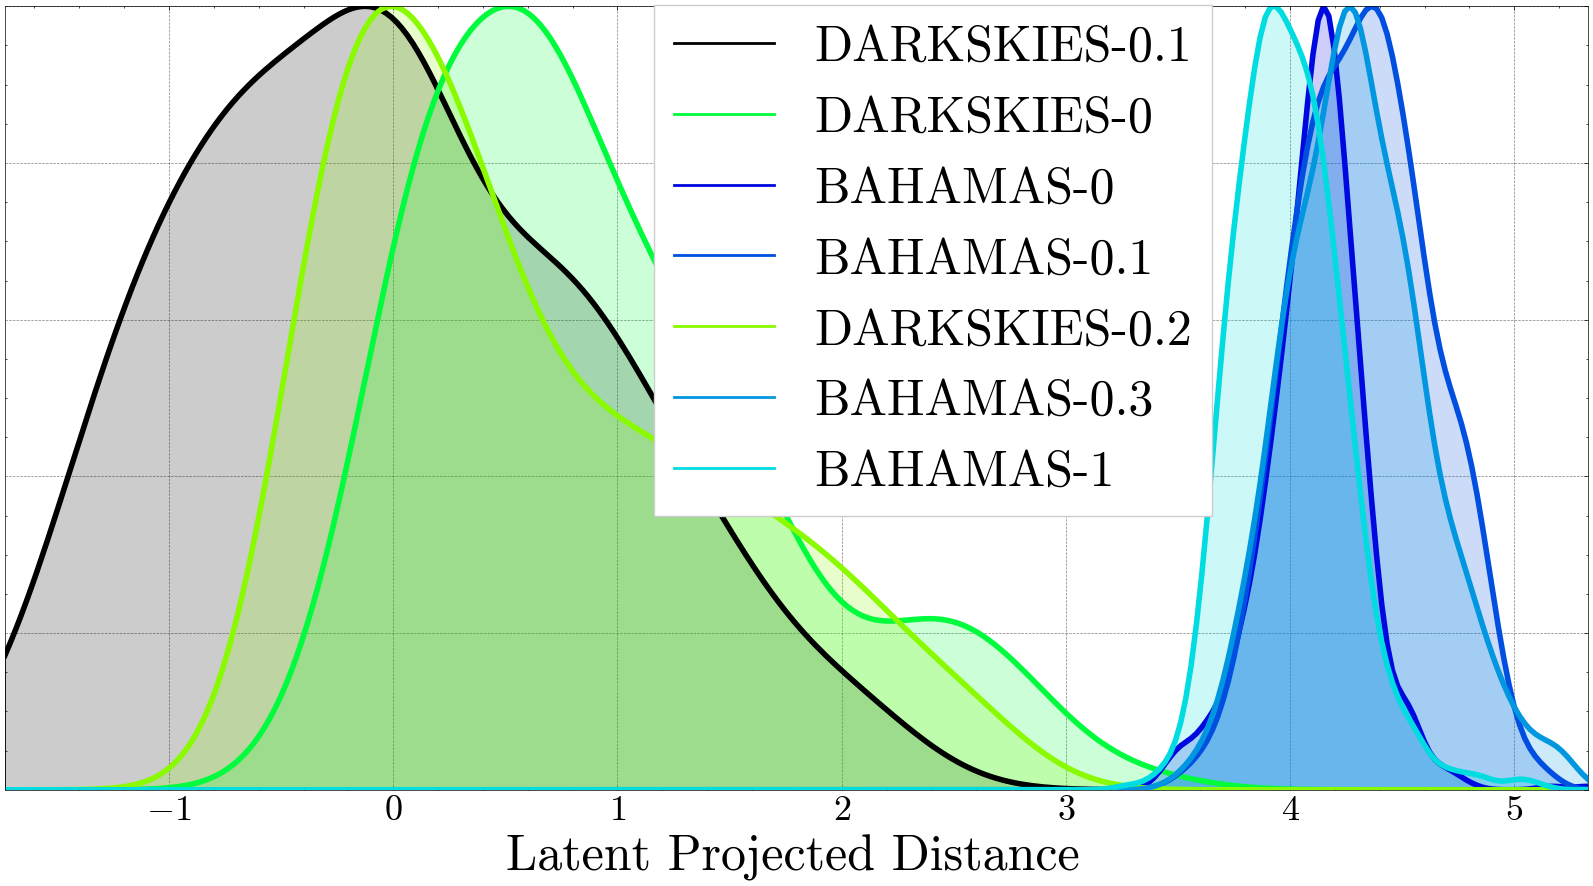

In [86]:
idx = 0
print(f"Target Sim: {labels[idx]}\n{'\n'.join(
    [f"Sim: {sim:<15}\tDistance: {stats.wasserstein_distance(*proj_vec):.2f}" for sim, proj_vec in zip(
        [label for label in labels if label != labels[idx]],
        proj_vecs[idx].swapaxes(0, 1),
    )])}")

plot = plots.PlotDistribution(
    # [proj_vecs[idx, 0, 3], *proj_vecs[idx, 1, [0, 3, 4, 5, 6, 7]]],
    [proj_vecs[idx, 0, 0], *proj_vecs[idx, 1]],
    density=True,
    norm=True,
    bins=300,
    x_labels='Latent Projected Distance',
    # colours=[colours[idx]] + [colour for colour in colours if not np.isin(colour, np.array(colours)[[idx, 2, 3]])],
    colours=[colours[idx]] + [colour for colour in colours if not np.isin(colour, np.array(colours)[[idx]])],
    # labels=[labels[idx]] + [label for label in labels if not np.isin(label, labels[[idx, 2, 3]])],
    labels=[labels[idx]] + [label for label in labels if not np.isin(label, labels[[idx]])],
    axis=True,
    # frameon=False,
    cols=1,
    alpha_2d=0.2,
    loc=(0.41, 0.35),
    # loc='upper center',
    # title=f'Target Sim: {labels[idx]}',
    line_width=4,
    major=36,
    minor=26,
)

In [87]:
cdfs = []
for base_proj_vecs in proj_vecs:
    cdfs.append([])
    for proj_vec in base_proj_vecs.swapaxes(0, 1):
        grid = np.mgrid[np.min(np.concat(proj_vec)):np.max(np.concat(proj_vec)):500j]
        cdfs[-1].append([
            analysis.distribution_func(proj_vec[0], norm=True, cumulative=True, grid=grid)[1],
            analysis.distribution_func(proj_vec[1], norm=True, cumulative=True, grid=grid)[1],
        ])

cdfs = np.array(cdfs)

In [88]:
idx = 0
print(f'Target Sim: {labels[idx]}')
for label, proj_vec, cdf in zip([label for label in labels if label != labels[idx]], proj_vecs[idx].swapaxes(0, 1), cdfs[idx]):
    print(f'Sim: {label:<15}\tOverlap: {overlap(*proj_vec, bins=100):<5.2f}\tEMD: {np.mean(np.subtract(*cdf)):<5.2f}\tF-Stat: {stats.kstest(*proj_vec).statistic:.2f}')

Target Sim: DARKSKIES-0.1
Sim: DARKSKIES-0    	Overlap: 0.58 	EMD: 0.17 	F-Stat: 0.49
Sim: BAHAMAS-0      	Overlap: 0.00 	EMD: 0.73 	F-Stat: 1.00
Sim: BAHAMAS-0.1    	Overlap: 0.00 	EMD: 0.78 	F-Stat: 1.00
Sim: DARKSKIES-0.2  	Overlap: 0.74 	EMD: 0.12 	F-Stat: 0.33
Sim: BAHAMAS-0.3    	Overlap: 0.00 	EMD: 0.76 	F-Stat: 1.00
Sim: BAHAMAS-1      	Overlap: 0.00 	EMD: 0.72 	F-Stat: 1.00


In [ ]:
grid = np.mgrid[np.min(np.concat((proj_vecs[0][:, 0], proj_vecs[1]))):np.max(np.concat((proj_vecs[0][:, 0], proj_vecs[1]))):500j]
cdfs = [analysis.distribution_func(proj_vecs[0][:, 0], norm=True, cumulative=True, grid=grid)[1], analysis.distribution_func(proj_vecs[1], norm=True, cumulative=True, grid=grid)[1]]
stats.wasserstein_distance(*cdfs), stats.kstest(proj_vecs[0][:, 0], proj_vecs[1]).statistic

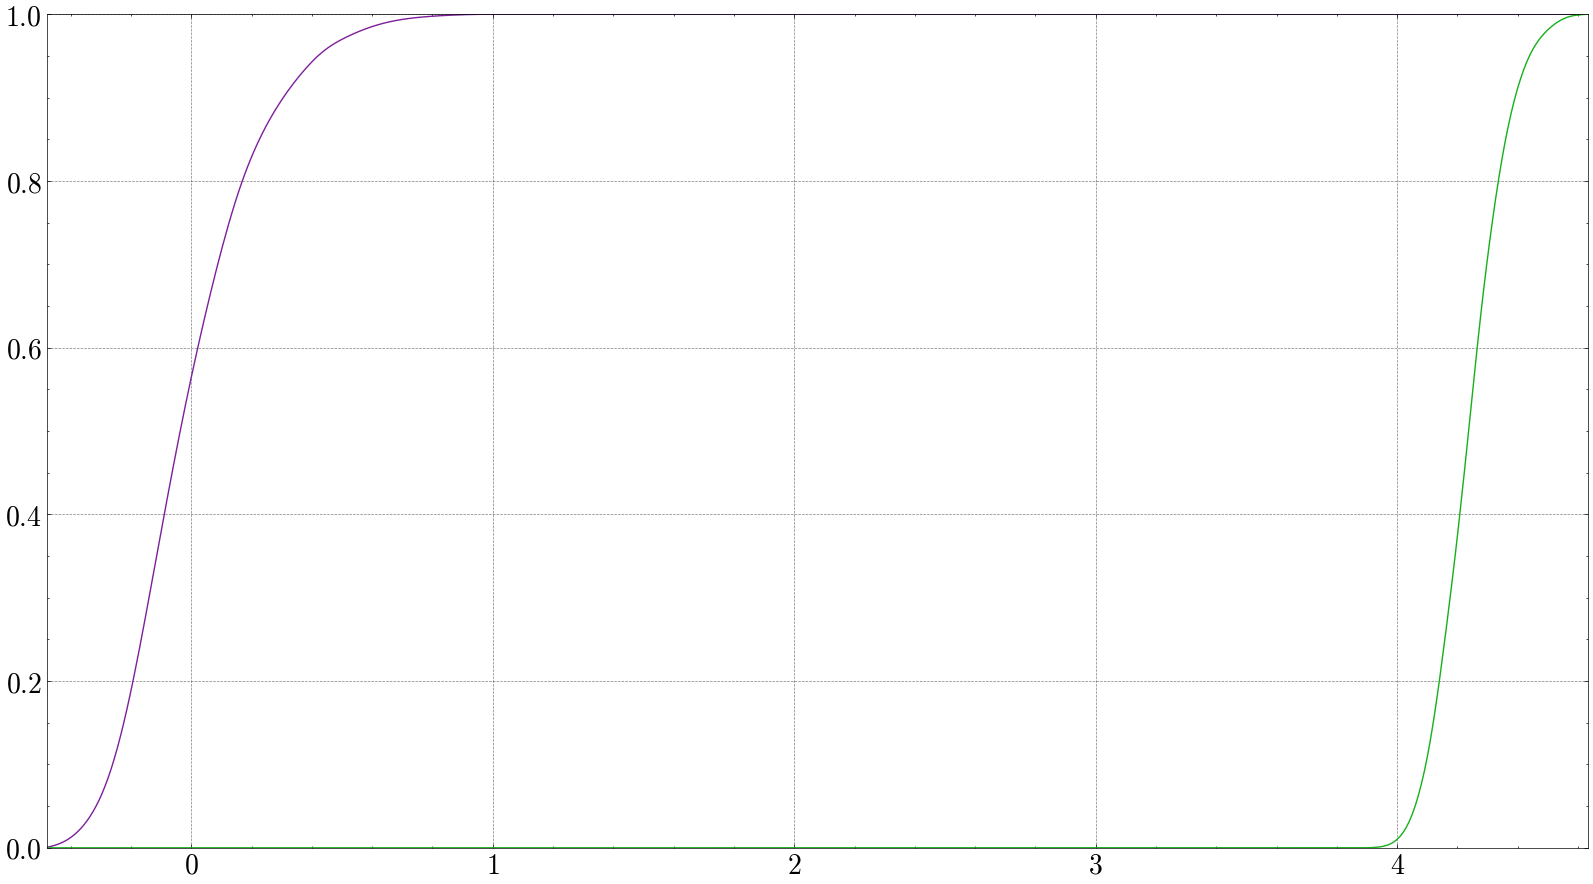

In [58]:
plots.PlotPlots(
    grid,
    cdfs,
    markers='',
)

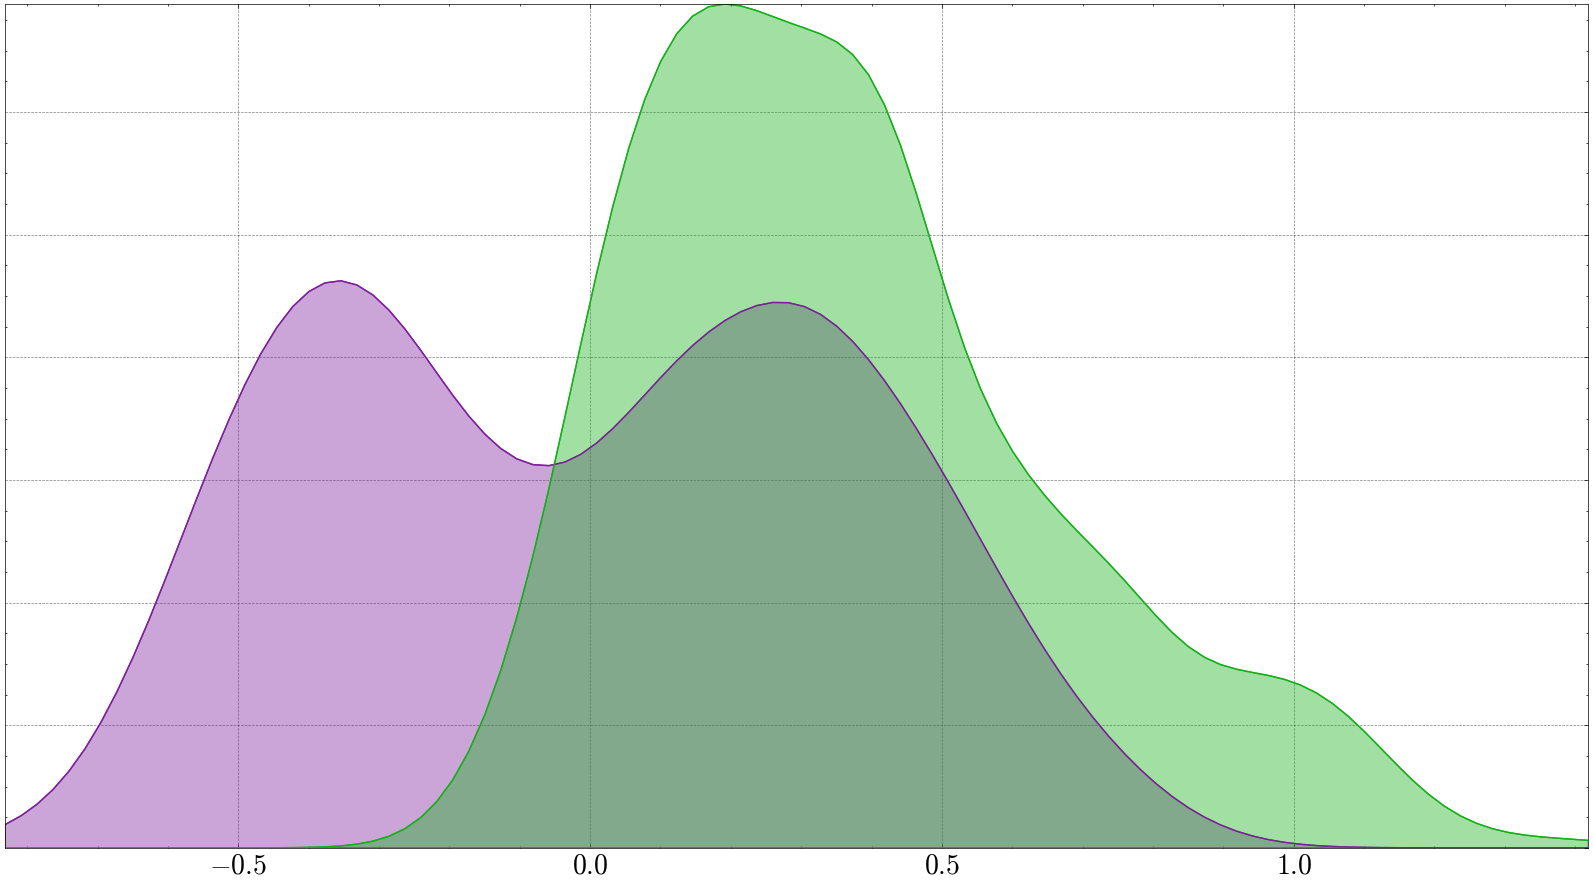

In [183]:
plots.PlotDistribution(
    [proj_vecs[0][:, 0], proj_vecs[1]],
    density=True,
)

In [105]:
# mmd = [3.7, 3.64, 3.71, 3.97]
mmd = [0.9, 1.59, 2.46]
np.mean(mmd), np.std(mmd, ddof=1) / np.sqrt(len(mmd))

(np.float64(1.6500000000000001), np.float64(0.45133136385587036))

In [125]:
idx = 3
overlap(proj_vecs[0][:, idx], proj_vecs[idx + 1], bins=100)

np.float64(0.678441530198636)

In [17]:
plot.savefig('../plots/', name='test')

In [223]:
range_ = (min(np.min(proj_vecs[0][:, 0]), np.min(proj_vecs[1])), max(np.max(proj_vecs[0][:, 0]), np.max(proj_vecs[1])))
# range_ = (np.min(proj_vecs[0][:, 0]), np.max(proj_vecs[0][:, 0]))
grid = np.mgrid[range_[0]:range_[1]:200j]
test_kernel = stats.gaussian_kde(proj_vecs[0][:, 0])
target_kernel = stats.gaussian_kde(proj_vecs[1])
test_pdf = test_kernel.pdf(grid)
target_pdf = target_kernel.pdf(grid)
# target_pdf = target_kernel.pdf()

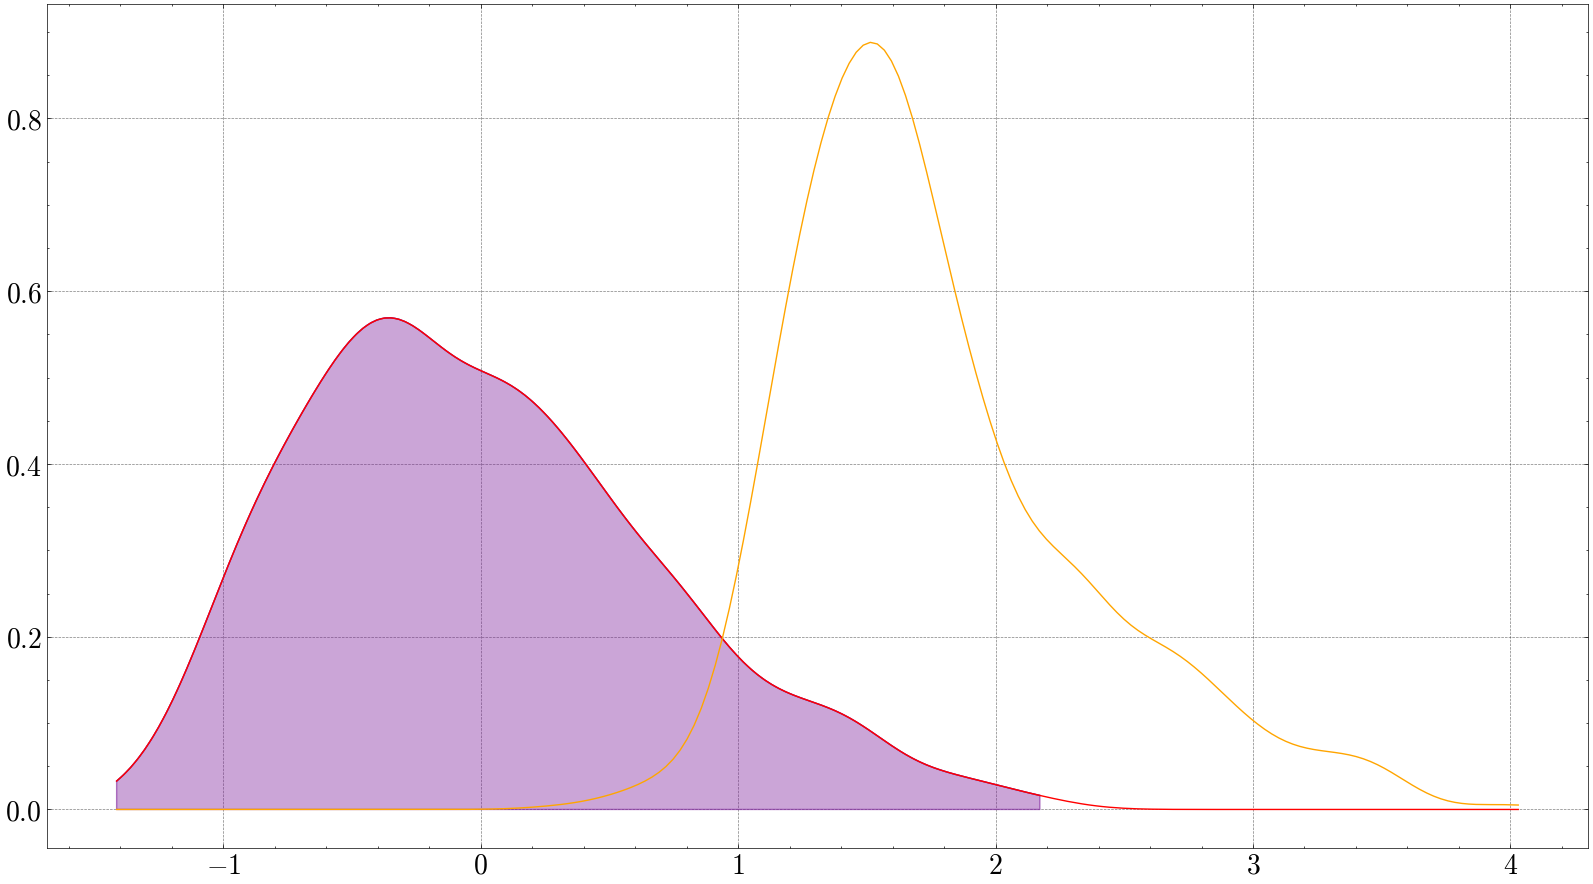

In [224]:
plot = plots.PlotDistribution(proj_vecs[0][:, 0], density=True, bins=200)
plot.axes.plot(grid, test_pdf, color='r')
plot.axes.plot(grid, target_pdf, color='orange')

In [225]:
# samples = test_kernel.resample(size=int(1e4))[0]
test_pdf = test_kernel.pdf(proj_vecs[0][:, 0])
target_pdf = target_kernel.pdf(proj_vecs[0][:, 0])
# torch.nn.functional.kl_div(torch.from_numpy(target_pdf).log(), torch.from_numpy(test_pdf))
np.mean(target_pdf * np.log(target_pdf / test_pdf))

np.float64(0.10677757033556624)

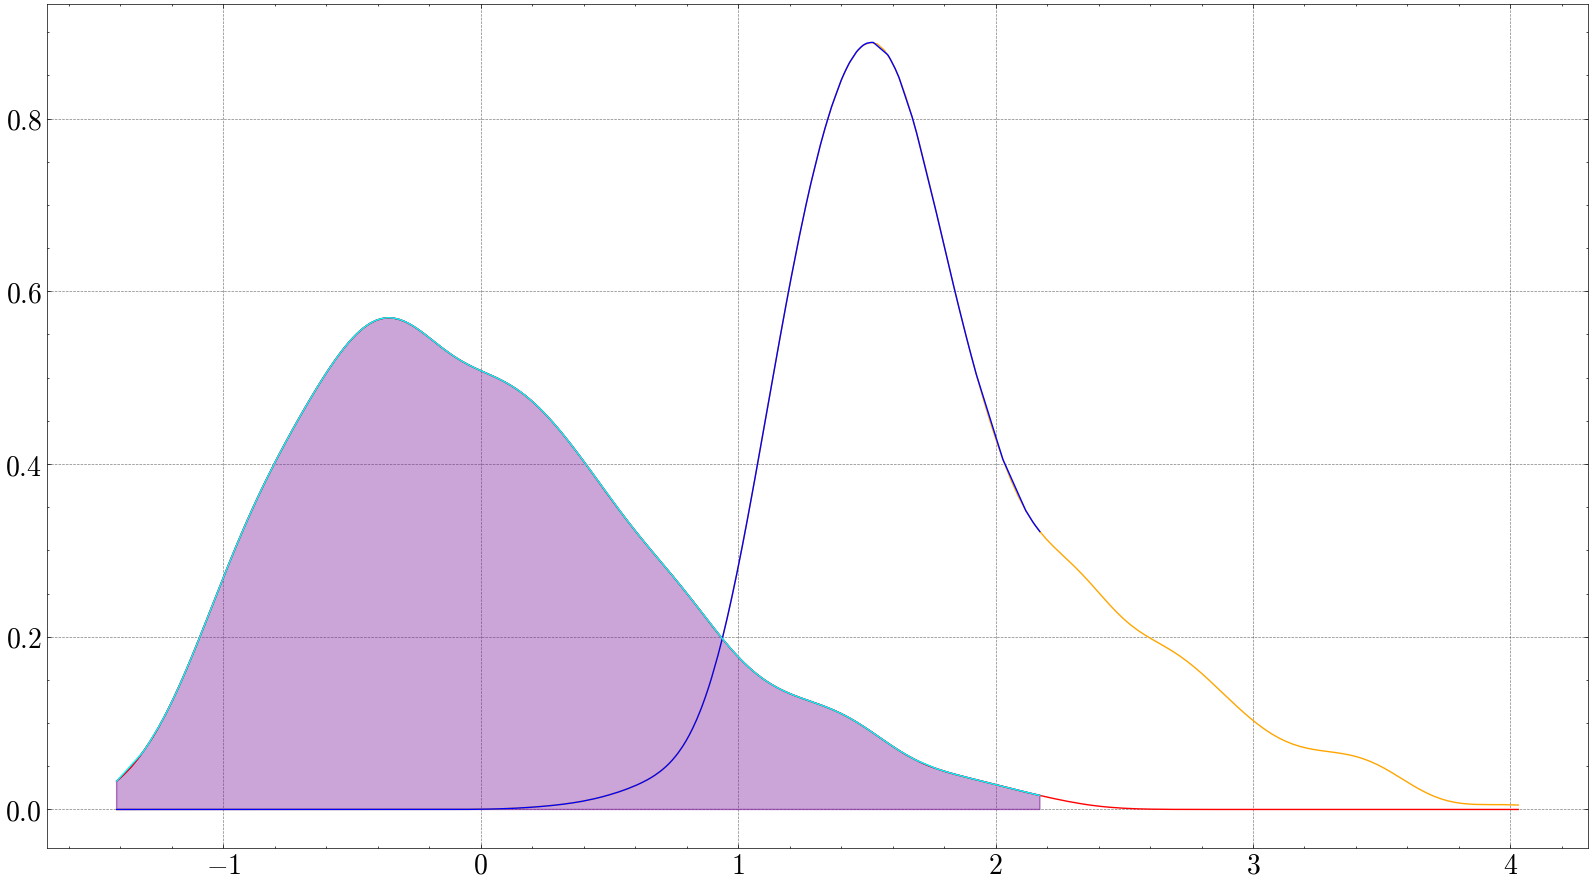

In [226]:
idxs = np.argsort(proj_vecs[0][:, 0])
plot.axes.plot(proj_vecs[0][idxs, 0], target_pdf[idxs], color='blue')
plot.axes.plot(proj_vecs[0][idxs, 0], test_pdf[idxs], color='cyan')
plot.fig